# Shell matrices and memory usage in `dynamite`

For this demonstration, we'll use the long-range XX+Z model we saw last time:

In [1]:
from dynamite.operators import sigmax, sigmaz, index_sum, op_sum

# the None default argument will be important later
def build_hamiltonian(L):
    interaction = op_sum(index_sum(sigmax(0)*sigmax(i), size=L) for i in range(1,L))
    uniform_field = 0.5*index_sum(sigmaz(), size=L)
    return interaction + uniform_field

# look at an example
build_hamiltonian(20)

dynamite.Operator on 20 spins:
index_sum(σx[0]*σx[1], sites 0 - 18) + index_sum(σx[0]*σx[2], sites 0 - 17) + index_sum(σx[0]*σx[3], sites 0 - 16) + ... + 0.500*[index_sum(σz[0], sites 0 - 19)]

Let's look at the structure of the matrix. `dynamite` uses sparse linear algebra, meaning that only nonzero matrix elements are stored. But the high connectivity of this model means that there are a good number of nonzero matrix elements:

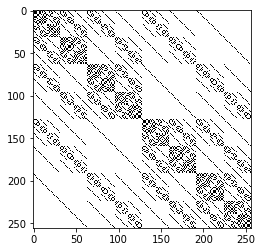

In [2]:
%matplotlib inline
H = build_hamiltonian(8)
H.spy()

This is a graphic representation of our matrix, where each black dot is a nonzero element. As we can see, the matrix is quite dense. We can quantitatively asses the density. For a Hamiltonian of size 20:

In [3]:
H = build_hamiltonian(20)

print('nonzeros per row:          ', H.nnz)
print('matrix dimension:          ', H.dim)
print('total nonzeros (nnz*nrows):', H.nnz*H.dim[0])
print('density (nnz/dim):         ', H.density)

nonzeros per row:           191
matrix dimension:           (1048576, 1048576)
total nonzeros (nnz*nrows): 200278016
density (nnz/dim):          0.00018215179443359375


That total number of nonzeros we need to store is a pretty big number. Let's look at our memory usage for a system of size 18:

In [6]:
from dynamite.tools import get_cur_memory_usage
from timeit import timeit

H = build_hamiltonian(18)

before = get_cur_memory_usage()
duration = timeit(H.build_mat, number=1, globals=globals())
after = get_cur_memory_usage()

print('matrix memory usage: %f Mb' % ((after-before)/1E6))
print('matrix build time: %f s' % duration)

matrix memory usage: 815.587328 Mb
matrix build time: 5.726535 s


This isn't even a very large number of particles, and the memory usage is already almost a gigabyte. Also, building the matrix is time consuming. Fortunately, dynamite has built-in "matrix-free" methods, which compute matrix elements on-the-fly when needed, and never store them. Let's see the memory usage for a shell matrix:

In [7]:
H.shell = 'cpu'

before = get_cur_memory_usage()
duration = timeit(H.build_mat, number=1, globals=globals())
after = get_cur_memory_usage()

print('matrix memory usage: %f Mb' % ((after-before)/1E6))
print('matrix build time: %f s' % duration)

matrix memory usage: 0.000000 Mb
matrix build time: 0.001995 s


The extra memory usage is obviously not zero. But it is small enough that it doesn't even get noticed by the memory tracker. And the matrix build time is almost nothing! That's because nothing is really being "built"---the matrix elements are computed on the fly when needed.

One might think that generating the matrix elements on the fly would incur a speed penalty. Let's compare the performance for a matrix-vector multiplication: 

In [8]:
H_noshell = H.copy()
H_noshell.shell = False
H_noshell.build_mat() # so we aren't counting this in the matrix-vector multiply time

In [9]:
from dynamite.states import State

# get states compatible with this operator
state, result = H.create_states()

no_shell_t = timeit("H_noshell.dot(state, result)", number=1, globals=globals())
shell_t = timeit("H.dot(state, result)", number=1, globals=globals())

print('Non-shell mat-vec multiply time: %f s' % no_shell_t)
print('Shell mat-vec multiply time:     %f s' % shell_t)

Non-shell mat-vec multiply time: 0.203423 s
Shell mat-vec multiply time:     0.243673 s


The performance is almost the same. Shell matrices do more work to compute the matrix elements on the fly, but they avoid memory bandwidth problems of storing the elements explicitly. Depending on the Hamiltonian's structure, the speed will vary, but they will always use much less memory.